In [1]:
# Import necessary packages
import os
import sklearn
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from dateutil.parser import parse
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from tensorflow.keras import Sequential
from tensorflow.keras.layers import LSTM, LeakyReLU, Dropout, Dense
from tensorflow.keras.callbacks import EarlyStopping

os.chdir("/home/maina/Documents/Air Pollution Monitoring")

# import data_retrival and analysis functions
from data_analysis import *

2022-01-12 23:26:14.263770: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-01-12 23:26:14.263795: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
# Gets the data from firebase, process it and store it in a csv file
filepath = read_data()

# Read the dataset as a pandas dataframe
df = pd.read_csv(filepath)

# Display the first 10 rows
df.head(10)

,timestamp,mq7,mq135,temperature,humidity
0,1639922725,162.0,39.0,24.1,73.0
1,1639923325,135.0,38.0,23.9,75.0
2,1639923927,118.0,36.0,24.0,72.0
3,1639924555,109.0,39.0,24.4,73.0
4,1639925428,102.0,42.0,24.2,74.0
5,1639926056,100.0,42.0,24.2,76.0
6,1639926658,97.0,40.0,24.2,75.0
7,1639927411,96.0,37.0,24.0,77.0
8,1639928191,92.0,37.0,23.9,77.0
9,1639928791,92.0,37.0,23.9,77.0


In [3]:
# Converting the unix time stamp to datetime format
df["timestamp"] = pd.to_datetime(df['timestamp'], unit='s')
df["timestamp"] = df["timestamp"].dt.tz_localize('Africa/Nairobi')
df.head()

,timestamp,mq7,mq135,temperature,humidity
0,2021-12-19 14:05:25+03:00,162.0,39.0,24.1,73.0
1,2021-12-19 14:15:25+03:00,135.0,38.0,23.9,75.0
2,2021-12-19 14:25:27+03:00,118.0,36.0,24.0,72.0
3,2021-12-19 14:35:55+03:00,109.0,39.0,24.4,73.0
4,2021-12-19 14:50:28+03:00,102.0,42.0,24.2,74.0


In [4]:
# Resapmle dataset hourly using mean
raw_df = df.set_index("timestamp")
df = raw_df.resample(rule='H').mean()
df.head()

,mq7,mq135,temperature,humidity
timestamp,,,,
2021-12-19 14:00:00+03:00,125.200000,38.800000,24.120000,73.400000
2021-12-19 15:00:00+03:00,95.000000,38.500000,23.983333,76.666667
2021-12-19 16:00:00+03:00,90.166667,36.166667,23.266667,77.666667
2021-12-19 17:00:00+03:00,97.200000,39.800000,23.240000,78.400000
2021-12-19 18:00:00+03:00,95.500000,39.500000,23.233333,79.833333


In [5]:
# Check if there are any missing values in the dataset
df.isnull().sum()

mq7            0
mq135          0
temperature    0
humidity       0
dtype: int64

In [6]:
# Statistical summary of the dataset columns
df.describe()

,mq7,mq135,temperature,humidity
count,352.000000,352.000000,352.000000,352.000000
mean,87.077023,42.029334,24.492894,62.310476
std,13.675241,7.418984,2.496454,10.194331
min,51.750000,27.833333,21.012821,29.800000
25%,79.437500,38.250000,22.991667,58.005357
50%,84.400000,40.200000,23.837500,66.055000
75%,91.312500,43.350000,25.227841,67.862672
max,153.166667,88.500000,34.000000,81.333333


array([<AxesSubplot:xlabel='timestamp'>, <AxesSubplot:xlabel='timestamp'>,
       <AxesSubplot:xlabel='timestamp'>, <AxesSubplot:xlabel='timestamp'>],
      dtype=object)

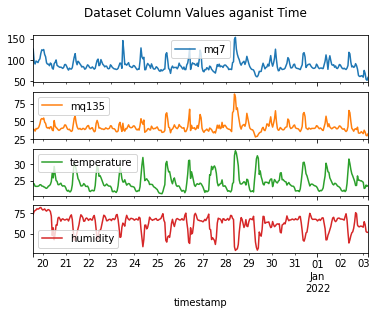

In [7]:
# plot the values against time
df[["mq7", "mq135", "temperature", "humidity"]].plot(subplots=True, title="Dataset Column Values aganist Time")

In [8]:
scaler = MinMaxScaler()
df.reset_index(inplace=True)
scaled_data = scaler.fit_transform(df.drop("timestamp", axis=1))

In [9]:
x = scaled_data
y = scaled_data[:,0]
y1 = scaled_data[:,1]


print(x.shape, y.shape, y1.shape)

(352, 4) (352,) (352,)


In [10]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=456, shuffle=False)
x_train1, x_test1, y_train1, y_test1 = train_test_split(x, y1, test_size=0.2, random_state=456, shuffle=False)

In [11]:
window_length = 6
num_features = 4
batch_size = 16
train_generator = TimeseriesGenerator(x_train, y_train, length=window_length, sampling_rate=1, batch_size=batch_size)
test_generator = TimeseriesGenerator(x_test, y_test, length=window_length, sampling_rate=1, batch_size=batch_size)

train_generator1 = TimeseriesGenerator(x_train1, y_train1, length=window_length, sampling_rate=1, batch_size=batch_size)
test_generator1 = TimeseriesGenerator(x_test1, y_test1, length=window_length, sampling_rate=1, batch_size=batch_size)

In [12]:
def make_model():
    model = Sequential()
    model.add(LSTM(128, input_shape=(window_length, num_features), return_sequences=True))
    model.add(LeakyReLU(alpha=0.5))
    model.add(LSTM(128, return_sequences=True))
    model.add(LeakyReLU(alpha=0.5))
    model.add(Dropout(0.5))
    model.add(LSTM(64, return_sequences=True))
    model.add(Dropout(0.3))
    model.add(Dense(1))

    model.summary()
    return model

In [13]:
early_stopping = EarlyStopping(
    monitor="val_loss",
    patience=3,
    mode="min"
                              )
mq7_model = make_model()
mq7_model.compile(optimizer="Adam", loss="mse", metrics=["mae"])

2022-01-12 23:26:18.566007: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-01-12 23:26:18.566034: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-01-12 23:26:18.566054: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (Pavilion): /proc/driver/nvidia/version does not exist
2022-01-12 23:26:18.566266: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 6, 128)            68096     
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 6, 128)            0         
                                                                 
 lstm_1 (LSTM)               (None, 6, 128)            131584    
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 6, 128)            0         
                                                                 
 dropout (Dropout)           (None, 6, 128)            0         
                                                                 
 lstm_2 (LSTM)               (None, 6, 64)             49408     
                                                                 
 dropout_1 (Dropout)         (None, 6, 64)             0

In [14]:
mq135_model = make_model()
mq135_model.compile(optimizer="Adam", loss="mse", metrics=["mae"])

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_3 (LSTM)               (None, 6, 128)            68096     
                                                                 
 leaky_re_lu_2 (LeakyReLU)   (None, 6, 128)            0         
                                                                 
 lstm_4 (LSTM)               (None, 6, 128)            131584    
                                                                 
 leaky_re_lu_3 (LeakyReLU)   (None, 6, 128)            0         
                                                                 
 dropout_2 (Dropout)         (None, 6, 128)            0         
                                                                 
 lstm_5 (LSTM)               (None, 6, 64)             49408     
                                                                 
 dropout_3 (Dropout)         (None, 6, 64)            

In [15]:
history1 = mq7_model.fit(
    train_generator, 
    epochs=100,
    validation_data=test_generator,
    shuffle=False,
    callbacks=[early_stopping]
                             )

Epoch 1/100
18/18 [==============================] - 5s 80ms/step - loss: 0.0793 - mae: 0.2365 - val_loss: 0.0357 - val_mae: 0.1512
Epoch 2/100
18/18 [==============================] - 0s 15ms/step - loss: 0.0420 - mae: 0.1566 - val_loss: 0.0289 - val_mae: 0.1359
Epoch 3/100
18/18 [==============================] - 0s 15ms/step - loss: 0.0309 - mae: 0.1280 - val_loss: 0.0223 - val_mae: 0.1141
Epoch 4/100
18/18 [==============================] - 0s 15ms/step - loss: 0.0254 - mae: 0.1144 - val_loss: 0.0208 - val_mae: 0.1102
Epoch 5/100
18/18 [==============================] - 0s 15ms/step - loss: 0.0232 - mae: 0.1094 - val_loss: 0.0198 - val_mae: 0.1069
Epoch 6/100
18/18 [==============================] - 0s 15ms/step - loss: 0.0217 - mae: 0.1050 - val_loss: 0.0183 - val_mae: 0.1004
Epoch 7/100
18/18 [==============================] - 0s 15ms/step - loss: 0.0206 - mae: 0.1012 - val_loss: 0.0176 - val_mae: 0.0976
Epoch 8/100
18/18 [==============================] - 0s 15ms/step - loss: 0.

In [16]:
history2 = mq135_model.fit(
    train_generator1, 
    epochs=100,
    validation_data=test_generator1,
    shuffle=False,
    callbacks=[early_stopping]
                             )

Epoch 1/100
18/18 [==============================] - 5s 72ms/step - loss: 0.0374 - mae: 0.1528 - val_loss: 0.0168 - val_mae: 0.0977
Epoch 2/100
18/18 [==============================] - 0s 15ms/step - loss: 0.0235 - mae: 0.1047 - val_loss: 0.0160 - val_mae: 0.1000
Epoch 3/100
18/18 [==============================] - 0s 15ms/step - loss: 0.0210 - mae: 0.0960 - val_loss: 0.0129 - val_mae: 0.0845
Epoch 4/100
18/18 [==============================] - 0s 16ms/step - loss: 0.0188 - mae: 0.0916 - val_loss: 0.0118 - val_mae: 0.0776
Epoch 5/100
18/18 [==============================] - 0s 15ms/step - loss: 0.0177 - mae: 0.0877 - val_loss: 0.0118 - val_mae: 0.0798
Epoch 6/100
18/18 [==============================] - 0s 16ms/step - loss: 0.0175 - mae: 0.0865 - val_loss: 0.0115 - val_mae: 0.0777
Epoch 7/100
18/18 [==============================] - 0s 16ms/step - loss: 0.0170 - mae: 0.0854 - val_loss: 0.0113 - val_mae: 0.0766
Epoch 8/100
18/18 [==============================] - 0s 15ms/step - loss: 0.

In [17]:
mq7_model.evaluate(test_generator)

5/5 [==============================] - 0s 3ms/step - loss: 0.0158 - mae: 0.0907


[0.01581045612692833, 0.09070440381765366]

In [18]:
mq135_model.evaluate(test_generator)

5/5 [==============================] - 0s 3ms/step - loss: 0.0202 - mae: 0.1122


[0.0201604962348938, 0.11215676367282867]

In [19]:
mq7_preds = mq7_model.predict(test_generator)
mq7_preds = mq7_preds.reshape(mq7_preds.shape[0], window_length)
mq7_preds.shape

(65, 6)

In [20]:
mq135_preds = mq135_model.predict(test_generator1)
mq135_preds = mq135_preds.reshape(mq7_preds.shape[0], window_length)
mq135_preds.shape

(65, 6)

In [21]:
df_mq7 = pd.concat([pd.DataFrame(mq7_preds[:,0]), pd.DataFrame(x_test[:,1:][window_length:])], axis=1)
reverse_transform = scaler.inverse_transform(df_mq7)
df_mq7_final = raw_df[df_mq7.shape[0]*-1:]
df_mq7_final["mq7_Predicted"] = reverse_transform[:,0]
df_mq7_final

/tmp/ipykernel_108966/1441113800.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_mq7_final["mq7_Predicted"] = reverse_transform[:,0]


,mq7,mq135,temperature,humidity,mq7_Predicted
timestamp,,,,,
2022-01-02 18:35:22+03:00,69.0,35.0,24.6,62.1,85.544957
2022-01-02 18:51:25+03:00,72.0,36.0,24.3,64.1,85.381962
2022-01-02 18:59:30+03:00,61.0,33.0,25.7,56.0,88.029497
2022-01-02 19:14:23+03:00,78.0,38.0,23.7,68.2,88.241011
2022-01-02 19:19:53+03:00,60.0,32.0,25.5,56.0,87.254595
...,...,...,...,...,...
2022-01-03 05:02:50+03:00,55.0,32.0,24.6,47.0,83.083487
2022-01-03 05:07:57+03:00,60.0,33.0,24.2,48.0,82.809846
2022-01-03 05:23:17+03:00,62.0,33.0,23.8,51.0,82.967059


<AxesSubplot:xlabel='timestamp', ylabel='PPM'>

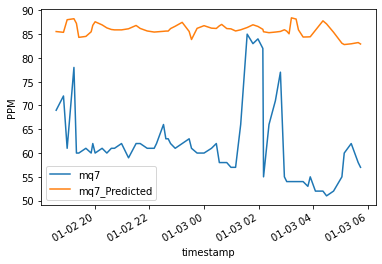

In [22]:
df_mq7_final[["mq7", "mq7_Predicted"]].plot(subplots=False, ylabel="PPM")

In [23]:
df_mq135 = pd.concat([pd.DataFrame(mq135_preds[:,1]), pd.DataFrame(x_test[:,1:][window_length:])], axis=1)
reverse_transform1 = scaler.inverse_transform(df_mq135)
df_mq135_final = raw_df[df_mq135.shape[0]*-1:]
df_mq135_final["mq135_Predicted"] = reverse_transform1[:,0]
df_mq135_final

/tmp/ipykernel_108966/347215071.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_mq135_final["mq135_Predicted"] = reverse_transform1[:,0]


,mq7,mq135,temperature,humidity,mq135_Predicted
timestamp,,,,,
2022-01-02 18:35:22+03:00,69.0,35.0,24.6,62.1,75.502179
2022-01-02 18:51:25+03:00,72.0,36.0,24.3,64.1,77.762928
2022-01-02 18:59:30+03:00,61.0,33.0,25.7,56.0,79.713752
2022-01-02 19:14:23+03:00,78.0,38.0,23.7,68.2,79.218892
2022-01-02 19:19:53+03:00,60.0,32.0,25.5,56.0,76.495623
...,...,...,...,...,...
2022-01-03 05:02:50+03:00,55.0,32.0,24.6,47.0,73.608918
2022-01-03 05:07:57+03:00,60.0,33.0,24.2,48.0,73.654334
2022-01-03 05:23:17+03:00,62.0,33.0,23.8,51.0,73.904460


<AxesSubplot:xlabel='timestamp', ylabel='PPM'>

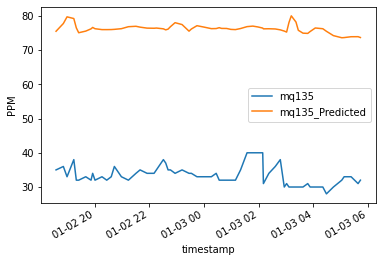

In [24]:
df_mq135_final[["mq135", "mq135_Predicted"]].plot(subplots=False, ylabel="PPM")

In [25]:
mq

NameError: name 'mq' is not defined